# Objectives

In this notebook, we will focus on on the following objectives:

- Constructing a diagnostic test by hard coding a straight line that stretches with no bending and remains on a fixed line throughout the entire deformation.

- Perhaps modifying the algorithm that finds the equilibrium displacements to allow rigid body movement.

- Removing the early polynomial fitting to instead use cornea tagged points directly and performing a very local fit at the end to get the new node positions. 

We first import the required modules.

In [1]:
import evolutionTools as evt
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from copy import deepcopy

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
starting_horizontal_points = np.linspace(0, 500, evt.N + 2)
static_y = np.zeros(starting_horizontal_points.shape[0])
initial_lengths = evt.initialLengthsFinder(starting_horizontal_points, static_y)

We will now stretch the line by only moving the extremities; this is because the edge displacements are forced to be zero by our minimizing algorithm, so we alter them and let the algorithm play on the displacement of the other nodes. We construct a time series using linear interpolation for a stretch that ends up doubling the initial length.

In [3]:
time_steps_stretch = 80
time_steps_contract = 100

In [4]:
displacements_stretch = np.linspace(0, 500, time_steps_stretch)
displacements_contract = np.linspace(0, 500, time_steps_contract)[::-1]
total_time_steps = time_steps_stretch + time_steps_contract

In [5]:
total_displacement_array = []
for i in displacements_stretch:
    total_displacement_array.append(i)
for j in displacements_contract:
    total_displacement_array.append(j)
total_displacement_array = np.array(total_displacement_array)

In [6]:
x_node_array = np.zeros((total_time_steps, starting_horizontal_points.shape[0]))
for i in range(x_node_array.shape[0]):
    #print(starting_horizontal_points)
    x_node_array[i] = starting_horizontal_points
    x_node_array[i][0] -= total_displacement_array[i]
    x_node_array[i][-1] += total_displacement_array[i]
    #print(x_node_array[i][-5:])

In [7]:
initial_guess = np.zeros(evt.N)
K_arr = np.ones(evt.N+1)

In [8]:
def add_noise(array, max_length_frac = 0.02):
    length = np.abs(array[0] - array[-1])
    return array + np.random.uniform(-1, 1) * max_length_frac * length

In [9]:
U_array = []
displacements_array = []
for i in range(total_time_steps):
    print(i)
    noisy_x = add_noise(x_node_array[i])
    noisy_y = add_noise(static_y)
    displacements = evt.minimize(evt.potentialEnergy, initial_guess, args = (noisy_x, noisy_y, initial_lengths, K_arr)).x
    initial_guess = displacements
    displacements_array.append(displacements)
    U_pot = evt.potentialEnergy(displacements, noisy_x, noisy_y, initial_lengths, K_arr)
    U_array.append(U_pot)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


In [10]:
example_data_displacement = pd.DataFrame(displacements_array)

In [11]:
example_data_displacement.to_csv('line_example/line_example_noise_displacements.csv', index = False)

In [12]:
example_data_potential = pd.DataFrame(U_array) # type: ignore

In [13]:
example_data_potential.to_csv('line_example/line_example_noise_potential.csv', index = False)

In [14]:
displacements = pd.read_csv('line_example/line_example_noise_displacements.csv').to_numpy()
potential = pd.read_csv('line_example/line_example_noise_potential.csv').to_numpy()[:,0]

Let us generate a video of the potential profile's evolution.

In [15]:
def formatted_frames(frames_directory, new_directory): #only new with /
    
    path = frames_directory
    mean_height = 0
    mean_width = 0
  
    num_of_images = len(os.listdir(path))
    
    for file in os.listdir(path): 
        im = evt.Image.open(os.path.join(path, file)) 
        width, height = im.size 
        mean_width += width 
        mean_height += height
    
    mean_width = int(mean_width / num_of_images) 
    mean_height = int(mean_height / num_of_images)
    
    imageIterator = 0
    
    while imageIterator <= num_of_images-1:
        imageName = str(imageIterator).zfill(3) + ".png"
        im = evt.Image.open(os.path.join(path, imageName))
        
        width, height = im.size 
        
        # resizing  
        imResize = im.resize((mean_width, mean_height), evt.Image.ANTIALIAS)  
        imResize.save(new_directory+str(imageIterator).zfill(3)+".png", quality = 95) # setting quality
        imageIterator+=1

# def generate_video(frames_directory, output_name):
#     image_folder = frames_directory
#     video_name = output_name
    
#     #must create the image array
    
#     num_of_images = len(os.listdir(image_folder))
#     imageIterator = 0
#     images=[]
    
#     while imageIterator <= num_of_images-1:
#         imageName = os.path.join(image_folder, str(imageIterator).zfill(3)+".png")
#         images.append(imageName)
#         imageIterator+=1
#     #print(images)
    
#     frame = evt.cv2.imread(images[0]) 
#     # setting the frame width, height width 
#     # the width, height of first image 
#     height, width, layers = frame.shape   
    
#     video = evt.cv2.VideoWriter(video_name,0x7634706d , 5, (width, height))  
  
#     # Appending the images to the video one by one 
#     for image in images:  
#         video.write(evt.cv2.imread(image))  
      
#     # Deallocating memories taken for window creation 
#     evt.cv2.destroyAllWindows()  
#     video.release()  # releasing the video generated



def generate_video(frames_directory, output_name):
    image_folder = frames_directory
    video_name = output_name
    
    # List all files in the directory and sort them
    images = sorted([img for img in os.listdir(image_folder) if img.endswith(".png")])
    
    # Ensure there are images in the directory
    if not images:
        raise ValueError("No images found in the provided directory.")
    
    # Read the first image to get dimensions
    first_frame = cv2.imread(os.path.join(image_folder, images[0]))
    if first_frame is None:
        raise ValueError("The first image could not be read. Please check the image files.")
    
    height, width, layers = first_frame.shape   
    
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Using 'mp4v' codec
    video = cv2.VideoWriter(video_name, fourcc, 5, (width, height))  
  
    # Add each image to the video
    for image in images:  
        frame = cv2.imread(os.path.join(image_folder, image))
        if frame is None:
            print(f"Warning: Image {image} could not be read. Skipping.")
            continue
        video.write(frame)
    
    # Release the video
    video.release()
    cv2.destroyAllWindows()


In [16]:
segment_points = np.arange(1, evt.N+2)
final_positions_array = deepcopy(x_node_array)
for i in range(final_positions_array.shape[0]):
    for j in range(final_positions_array.shape[1]):
        if j >= evt.N:
            continue
        else:
            final_positions_array[i][j+1] += displacements[i][j]

In [17]:
segment_energies = np.zeros((final_positions_array.shape[0], evt.N + 1))
for time_index in range(segment_energies.shape[0]):
    for node_index in range(evt.N+1):
        p1 = (final_positions_array[time_index][node_index], 0)
        p2 = (final_positions_array[time_index][node_index+1], 0)
        new_segment_length = evt.euclideanDistance(p1, p2)
        segment_energies[time_index][node_index] = 0.5 * K_arr[0] * (new_segment_length - initial_lengths[node_index])**2

In [18]:
segment_midpoints = np.zeros(segment_energies.shape)
for time_index in range(segment_energies.shape[0]):
    for node_index in range(evt.N+1):
        p1 = (final_positions_array[time_index][node_index], 0)
        p2 = (final_positions_array[time_index][node_index+1], 0)
        midpoint = (p1[0] + p2[0])/2
        segment_midpoints[time_index][node_index] = midpoint

In [27]:
def make_line_displacement_frames(displacements, potential, path_to_frames = 'line_example/NOISE_DISPLACEMENT_FRAMES/'):
    #read - in as pd.DataFrame.to_numpy() for displacements and squeezed axis 1 for potential
    for i in range(potential.shape[0]):
        plt.figure(figsize = (15,12))
        plt.plot(x_node_array[i][1:-1], displacements[i])
        plt.title("Displacement Versus Initial Free Node Position on Time Step: " + str(i).zfill(3))
        plt.ylim((-500,500))
        plt.xlim((0,600))
        plt.savefig(path_to_frames+str(i).zfill(3)+".png")
        plt.close()

def make_line_potential_frames(segment_midpoints, segment_energies, path_to_frames = 'line_example/NOISE_POTENTIAL_FRAMES/'):
    #read - in as pd.DataFrame.to_numpy() for displacements and squeezed axis 1 for potential
    for time_index in range(potential.shape[0]):
        plt.figure(figsize = (15,12))
        plt.plot(segment_midpoints[time_index], segment_energies[time_index])
        plt.title("Potential Profile on Frame " + str(time_index).zfill(3))
        plt.ylim((0,400))
        plt.xlim((-550,1550))
        plt.savefig(path_to_frames+str(time_index).zfill(3)+".png")
        plt.close()


In [20]:
make_line_displacement_frames(displacements, potential)

In [28]:
make_line_potential_frames(segment_midpoints, segment_energies)

In [22]:
formatted_frames('line_example/NOISE_DISPLACEMENT_FRAMES', 'line_example/TRIMMED_NOISE_DISPLACEMENT_FRAMES/')

In [29]:
formatted_frames('line_example/NOISE_POTENTIAL_FRAMES', 'line_example/TRIMMED_NOISE_POTENTIAL_FRAMES/')

In [24]:
generate_video('line_example/TRIMMED_NOISE_DISPLACEMENT_FRAMES', 'line_example/noise_displacement_evolution.mp4')

In [30]:
generate_video('line_example/TRIMMED_NOISE_POTENTIAL_FRAMES', 'line_example/noise_potential_evolution.mp4')

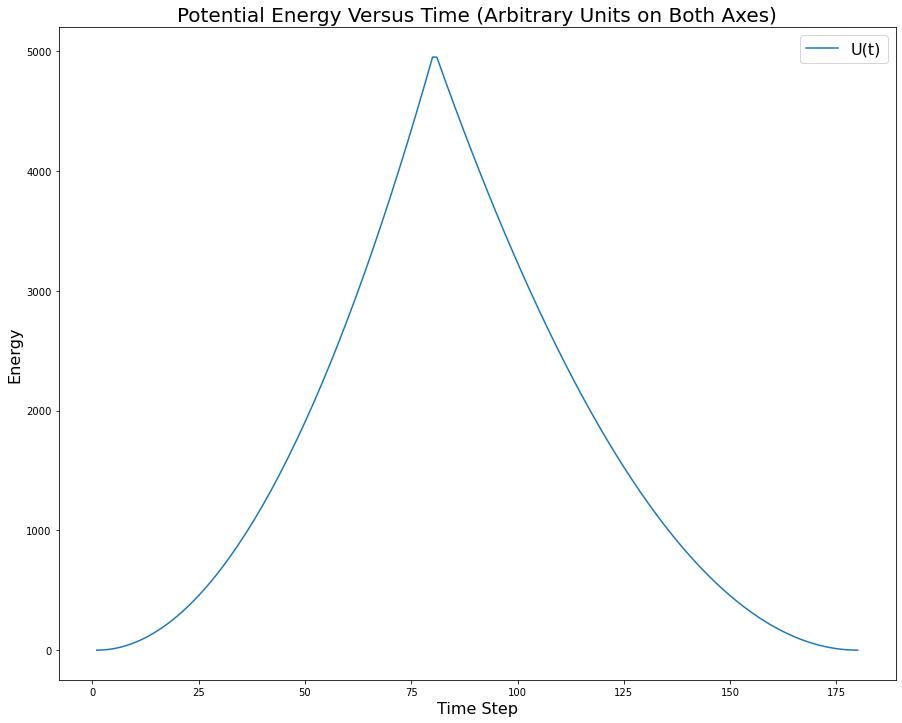

In [26]:
plt.figure(figsize=(15, 12))
plt.plot(np.arange(1, total_time_steps + 1), potential, label = 'U(t)')
plt.title( 'Potential Energy Versus Time (Arbitrary Units on Both Axes)', fontsize = 20)
plt.xlabel('Time Step', fontsize = 16)
plt.ylabel('Energy', fontsize = 16)
plt.legend(fontsize = 16)
plt.savefig('line_example/noise_energy_time_plot.png')

Evidently, the approach works perfectly.